In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pywt
import time

In [2]:
zip_file_path = './task2.zip'
extraction_directory = 'extracted_images/'

In [3]:
y_train = pd.read_csv(extraction_directory + 'y_train.csv', index_col='id')
y_train_np = y_train.to_numpy()

In [4]:
X_train = pd.read_csv(extraction_directory + 'X_train.csv', index_col='id')
X_train_np = X_train.to_numpy()

In [5]:
def replicate_row(row):
    # Find the length of the non-NaN part
    valid_length = np.argmax(row.isna())
    valid_length = valid_length if valid_length > 0 else len(row)

    # Repeat the non-NaN part and truncate to match the original length
    repeated = np.tile(row[:valid_length], len(row) // valid_length + 1)[:len(row)]
    return pd.Series(repeated)

start = time.time()

X_train_periodic = X_train.apply(replicate_row, axis=1)

end = time.time()
print(f"Time taken: {end - start} seconds")

Time taken: 0.9898059368133545 seconds


In [6]:
X_train_periodic_np = X_train_periodic.to_numpy()

In [7]:
from numpy.random import RandomState

prng = RandomState(1)

def augment_signal(signal, max_shift, scaling_factor_range, noise_level, max_freq_change):
    signal = signal.copy()
    # Time Shifting
    if max_shift > 0:
        shift = prng.randint(-max_shift, max_shift)
        signal = np.roll(signal, shift)

    # Scaling
    if scaling_factor_range > 0:
        signal *= prng.uniform(1 - scaling_factor_range, 1 + scaling_factor_range)

    # Adding Noise
    if noise_level > 0:
        signal += pd.DataFrame(prng.normal(0, noise_level, size=signal.size + 500)).rolling(window=500).median().to_numpy().squeeze()[500:]

    # Frequency Change (Resampling)
    if max_freq_change > 0:
        freq_change = prng.uniform(1 - max_freq_change, 1 + max_freq_change)
        resample_size = int(len(signal) * freq_change)
        if freq_change > 1:
            signal = np.interp(np.linspace(0, 1, resample_size), np.linspace(0, 1, len(signal)), signal)[:signal.size]
        elif freq_change < 1:
            signal = np.tile(np.interp(np.linspace(0, 1, resample_size), np.linspace(0, 1, len(signal)), signal), 2)[:signal.size]
    return signal


In [8]:
class_distribution = y_train.apply(lambda x: {i: x[x == i].count() for i in range(4)})['y']
print('Original:')
for name in class_distribution:
    print(str(name) + ': {:} = {:.2%}'.format(class_distribution[name] , class_distribution[name] / y_train_np.size))
print('')

y_train_np = y_train.to_numpy().squeeze()

# Parameters for augmentation
max_shift = 450  # Maximum shift for time shifting
scaling_factor_range = 0.05  # Scaling factor range for scaling
noise_level = 1500  # Noise level for adding noise
max_freq_change = 0.01  # Maximum frequency change for resampling

# Augmenting the dataset
X_augmented = []
y_augmented = []

for class_label in [0]*1 + [1]*12 + [2]*3 + [3]*33:
    for i in range(X_train.shape[0]):
        if y_train_np[i] == class_label:  # Define your threshold
            augmented_signal = augment_signal(X_train_periodic_np[i], max_shift, scaling_factor_range, noise_level, max_freq_change)
            X_augmented.append(augmented_signal)
            y_augmented.append(class_label)

# Convert augmented data to numpy arrays and add to original dataset
X_augmented = np.array(X_augmented)
y_augmented = np.array(y_augmented)

X_train_extended_np = np.concatenate((X_train_periodic_np, X_augmented))
y_train_extended_np = np.concatenate((y_train_np, y_augmented))

X_train_extended = pd.DataFrame(X_train_extended_np, columns=X_train.columns)
y_train_extended = pd.DataFrame(y_train_extended_np, columns=y_train.columns)

class_distribution_extended = y_train_extended.apply(lambda x: {i: x[x == i].count() for i in range(4)})['y']
print('Extended:')
for name in class_distribution_extended:
    print(str(name) + ': {:} = {:.2%}'.format(class_distribution_extended[name], class_distribution_extended[name] / y_train_extended_np.size))

Original:
0: 3030 = 59.21%
1: 443 = 8.66%
2: 1474 = 28.81%
3: 170 = 3.32%

Extended:
0: 6060 = 25.79%
1: 5759 = 24.51%
2: 5896 = 25.09%
3: 5780 = 24.60%


In [9]:
def get_median_filter_width(sampling_rate, duration):
    res = int( sampling_rate*duration )
    res += ((res%2) - 1) # needs to be an odd number
    return res

# ms_flt_array = [0.2,0.6]
ms_flt_array = [0.4,0.8]

def filter_line(data, ms_flt_array):
    data = data.copy()

    for i in range(0, len(ms_flt_array)):
        window_size = get_median_filter_width(300, ms_flt_array[i])

        data -= data.apply(lambda x: x.rolling(window=window_size, center=True, min_periods=1).median(), axis=1)

    return data

X_train_filtered = filter_line(X_train_extended, ms_flt_array)
X_train_filtered_np = X_train_filtered.to_numpy()

In [10]:
total_length = X_train.shape[1]

def denoise_signal_with_selective_thresholding(signal, wavelet, level, qrs_band=(5, 15), sampling_rate=300, dampening=2):
    # Decompose to get the wavelet coefficients
    coeffs = pywt.wavedec(signal, wavelet, level=level)

    # Calculate the frequency bands for each level of decomposition
    freqs = pywt.scale2frequency(wavelet, [1, 2, 4, 8, 16, 32, 64]) * sampling_rate

    # Calculate a universal threshold
    sigma = np.median(np.abs(coeffs[-level])) / 0.6745
    threshold = sigma * np.sqrt(2 * np.log(len(signal)))

    # Apply selective thresholding
    new_coeffs = []
    for i, coeff in enumerate(coeffs[1:], start=1):  # Skip the approximation coefficients
        if freqs[i-1] >= qrs_band[0] and freqs[i-1] <= qrs_band[1]:
            # If within QRS band, apply a softer threshold or skip thresholding
            new_coeffs.append(pywt.threshold(coeff, value=threshold/dampening, mode='soft'))
        else:
            # Else, apply the regular threshold
            new_coeffs.append(pywt.threshold(coeff, value=threshold, mode='soft'))
    
    # Reconstruct the signal using modified coefficients
    coeffs[1:] = new_coeffs
    return pywt.waverec(coeffs, wavelet)

def process_signal(signal, wavelet, level, qrs_band=(5, 15), sampling_rate=300, dampening=2):
    global total_length
    # Find the index of the first NaN value
    nan_index = np.argmax(np.isnan(signal))
    if nan_index == 0:  # No NaNs found
        return denoise_signal_with_selective_thresholding(signal, wavelet, level, qrs_band=qrs_band, sampling_rate=sampling_rate, dampening=dampening)
    
    a = np.empty((total_length-nan_index,))
    a[:] = np.nan

    return np.concatenate([denoise_signal_with_selective_thresholding(signal[:nan_index], wavelet, level, qrs_band=qrs_band, sampling_rate=sampling_rate, dampening=dampening), a])[0:total_length]

In [11]:
wavelet = 'db4'  # Example wavelet, choose as per your requirement
level = 3 # Decomposition level
qrs_band = (50, 150)  # Frequency band of QRS complex in Hz
sampling_rate = 300  # Sampling rate of ECG signal in Hz
dampening = 1

X_train_denoised_np = np.array([process_signal(row, wavelet, level, qrs_band, sampling_rate, dampening)[0:total_length] for row in X_train_filtered_np])
X_train_denoised = pd.DataFrame(data=X_train_denoised_np, columns=X_train_extended.columns, index=X_train_extended.index)

In [12]:
from biosppy.signals.ecg import correct_rpeaks
from ecgdetectors import Detectors
import biosppy.signals.ecg as ecg

# from sklearn.preprocessing import RobustScaler, StandardScaler

In [13]:
def normalize_signal(signal):

    detectors = Detectors(300)

    r_peaks = correct_rpeaks(signal, np.asarray(detectors.pan_tompkins_detector(signal)), 300, 0.2)['rpeaks']
    vals_peaks = signal[r_peaks]
    median_peak_val = np.median(vals_peaks[~np.isnan(vals_peaks)])
    
    if median_peak_val != 0:
        if np.isnan(median_peak_val).any():
            print(median_peak_val)
        return signal / median_peak_val
    # else:
    #     print(median_peak_val)
    #     return RobustScaler(quantile_range=(.2,.8)).fit_transform(signal.T).T/5

X_train_transformed_np = np.apply_along_axis(normalize_signal, 1, X_train_denoised_np)
X_train_transformed = pd.DataFrame(data=X_train_transformed_np, columns=X_train_denoised.columns, index=X_train_denoised.index)

In [14]:
def plot_features(signal):
    
    detectors = Detectors(300)

    r_peaks = correct_rpeaks(signal, np.asarray(detectors.pan_tompkins_detector(signal)), 300, 0.2)['rpeaks']
    
    #print(r_peaks)
    if len(r_peaks) >= 2:
        #print(ecg.extract_heartbeats(signal, r_peaks, 300))
        beats = ecg.extract_heartbeats(signal, r_peaks, 300, before=.5, after=.5)['templates']

        if len(beats) != 0:
            mu = np.mean(beats, axis=0) 
            var = np.std(beats, axis=0)
            md = np.median(beats, axis=0)
            
            plt.plot(range(mu.shape[0]), mu, label='Average HeartBeat')
            # Fill the variance range
            plt.fill_between(range(mu.shape[0]), mu - var, mu + var, linewidth=0, alpha=0.1)
            # Plot a median
            plt.plot(range(md.shape[0]), md, label='Median HeartBeat', color='#CC4F1B')
            plt.legend()

In [15]:
# Downscaling
X_train_ready_np = X_train_transformed_np[:,:-1:2]
X_train_ready = pd.DataFrame(X_train_ready_np)

# OBTAIN TEST DATA

In [16]:
X_test  = pd.read_csv(extraction_directory + 'X_test.csv', index_col='id')
X_test_np = X_test.to_numpy()

X_test_periodic = X_test.apply(replicate_row, axis=1)
X_test_periodic_np = X_test_periodic.to_numpy()

X_test_filtered = filter_line(X_test_periodic, ms_flt_array)
X_test_filtered_np = X_test_filtered.to_numpy()

X_test_denoised_np = np.array([process_signal(row, wavelet, level, qrs_band, sampling_rate, dampening)[0:total_length] for row in X_test_filtered_np])
X_test_denoised = pd.DataFrame(data=X_test_denoised_np, columns=X_test.columns, index=X_test.index)

X_test_transformed_np = np.apply_along_axis(normalize_signal, 1, X_test_denoised_np)
X_test_transformed = pd.DataFrame(data=X_test_transformed_np, columns=X_test.columns, index=X_test.index)

X_test_ready_np = X_test_transformed_np[:,:-1:2]
X_test_ready = pd.DataFrame(X_test_ready_np)


# MODEL TRAINING

In [17]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score
from keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, BatchNormalization, Dropout, Conv1D, Flatten, MaxPooling1D, Input, Concatenate, GlobalAveragePooling1D, Activation
from keras.metrics import AUC
from tensorflow.keras.utils import to_categorical
from keras.callbacks import ModelCheckpoint, EarlyStopping
from keras.optimizers import Adam
from keras.callbacks import ReduceLROnPlateau, EarlyStopping
import tensorflow as tf
from keras.layers import Input, concatenate
from keras.models import Model

/Users/rcasado/Desktop/Rodrigo_work/Universidad/PhD/Other/Coding/Visual Studio Code/.venv/lib/python3.9/site-packages/urllib3/__init__.py:34: NotOpenSSLWarning: urllib3 v2.0 only supports OpenSSL 1.1.1+, currently the 'ssl' module is compiled with 'LibreSSL 2.8.3'. See: https://github.com/urllib3/urllib3/issues/3020
  warnings.warn(


In [18]:
# Convert labels to categorical
y_train_cat_np = to_categorical(y_train_extended.to_numpy())

# Split data
X_train_partial, X_val, y_train_partial, y_val = train_test_split(X_train_ready_np, y_train_cat_np, test_size=0.2, random_state=23)

In [19]:
learning_rate = 5e-3                            # learning rate of the gradient descent
LAMBD = 3e-3                         # lambda in L2 regularizaion
dropout = 0.3                             # dropout rate
dropout_CNN = .3
dropout_RNN = .3
recurrent_dropout = 0.3

In [20]:
# Model parameters
input_shape = (X_train_partial.shape[1], 1)  # Replace 'None' with your input length
num_classes = 4
dropout_rate = 0.3

model = Sequential()

for _ in range(5):
    model.add(Conv1D(32, 5, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))

# Global Average Pooling
model.add(GlobalAveragePooling1D())

fc_neurons = [32, 32, 16]
for neurons in fc_neurons:
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))

# Softmax output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
print(model.summary())

# Model summary
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d (Conv1D)             (None, 8903, 32)          192       
                                                                 
 max_pooling1d (MaxPooling1  (None, 4451, 32)          0         
 D)                                                              
                                                                 
 dropout (Dropout)           (None, 4451, 32)          0         
                                                                 
 conv1d_1 (Conv1D)           (None, 4451, 32)          5152      
                                                                 
 max_pooling1d_1 (MaxPoolin  (None, 2225, 32)          0         
 g1D)                                                            
                                                                 
 dropout_1 (Dropout)         (None, 2225, 32)          0

In [21]:
# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=5,
                             verbose=0,
                             factor=0.5,
                             min_lr=1e-8)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0, 
                           patience=300,
                           verbose=1,
                           mode='max',
                           baseline=0.75,
                           start_from_epoch=1,
                           restore_best_weights=True)

In [22]:
start = time.time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=1500,
                    batch_size=1024,
                    validation_split=0.0,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    callbacks=[lr_decay],
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

Epoch 1/1500
19/19 [==============================] - 31s 2s/step - loss: 1.3645 - accuracy: 0.3202 - val_loss: 1.3215 - val_accuracy: 0.3554 - lr: 0.0050
Epoch 2/1500
19/19 [==============================] - 30s 2s/step - loss: 1.2850 - accuracy: 0.3835 - val_loss: 1.2066 - val_accuracy: 0.4207 - lr: 0.0050
Epoch 3/1500
19/19 [==============================] - 31s 2s/step - loss: 1.1949 - accuracy: 0.4109 - val_loss: 1.0842 - val_accuracy: 0.4780 - lr: 0.0050
Epoch 4/1500
19/19 [==============================] - 30s 2s/step - loss: 1.1199 - accuracy: 0.4425 - val_loss: 1.0438 - val_accuracy: 0.4944 - lr: 0.0050
Epoch 5/1500
19/19 [==============================] - 30s 2s/step - loss: 1.0903 - accuracy: 0.4543 - val_loss: 1.0249 - val_accuracy: 0.4882 - lr: 0.0050
Epoch 6/1500
19/19 [==============================] - 30s 2s/step - loss: 1.0647 - accuracy: 0.4674 - val_loss: 1.0042 - val_accuracy: 0.4899 - lr: 0.0050
Epoch 7/1500
19/19 [==============================] - 30s 2s/step - lo

In [23]:
model.save("model_CNN_simple1.keras")

1/1 [==============================] - 2s 2s/step - loss: 0.4462 - accuracy: 0.8114
-----------------------------------------------------------------
train accuracy = 82.3526%
test accuracy = 81.1449%


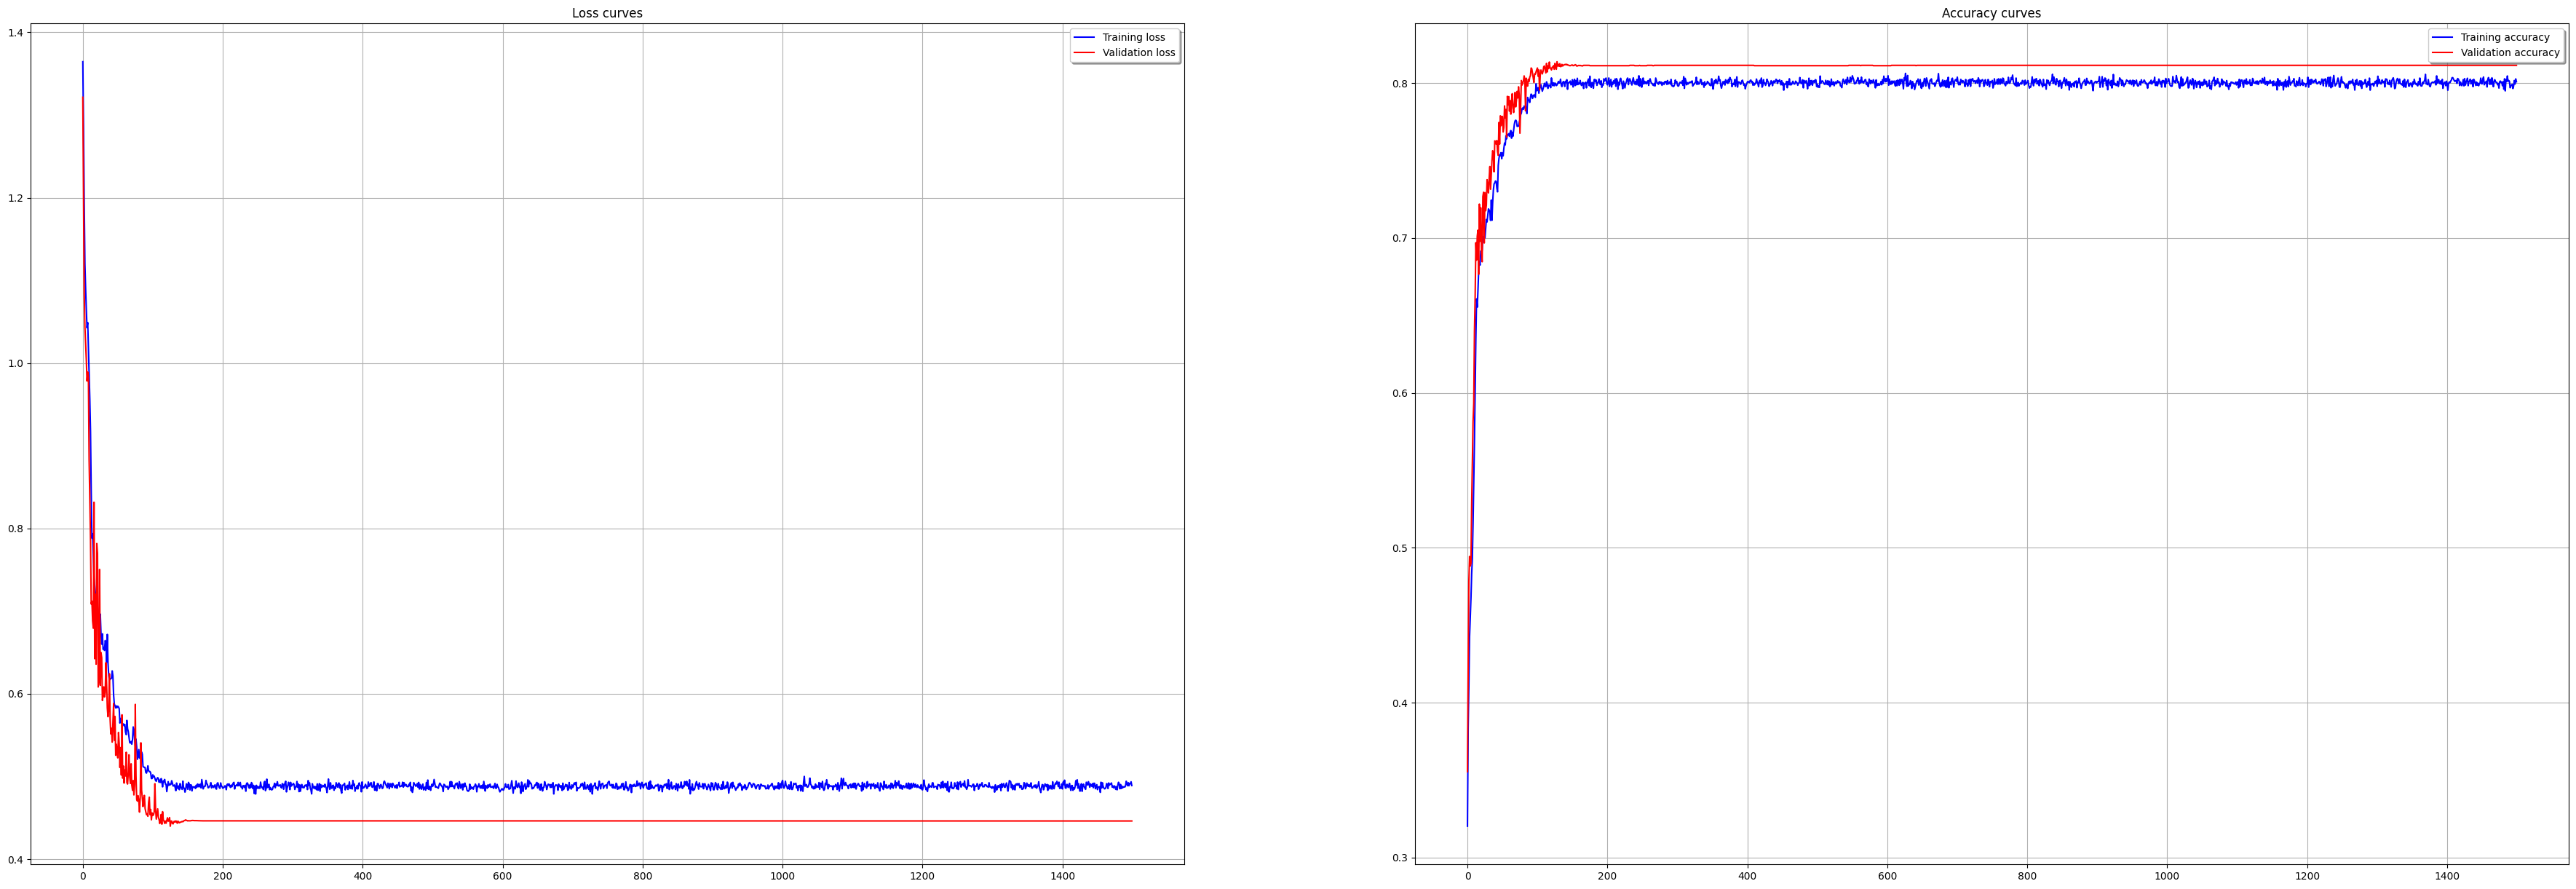

147/147 [==============================] - 3s 17ms/step
0.8114492445201107


In [24]:
# Evaluate the model:
train_loss, train_accuracy = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=X_train_partial.shape[1],
                                       verbose=1)

test_loss, test_accuracy = model.evaluate(X_val,
                                                    y_val,
                                                    batch_size=X_train_partial.shape[1],
                                                    verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(45,15))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].grid()
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].grid()
axs[1].legend(loc='best', shadow=True)
plt.show()

y_pred = model.predict(X_val)
print(f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average='micro'))

In [25]:
y_test_pred_np = model.predict(X_test_ready_np)

y_test_pred_class_np = y_test_pred_np.argmax(axis=1)

y_test_pred_class = pd.DataFrame(data={'id': range(y_test_pred_class_np.shape[0]), 'y': y_test_pred_class_np})
y_test_pred_class.to_csv('sol_CNN_simple2.csv', columns=['id', 'y'], index = False)

107/107 [==============================] - 2s 18ms/step


In [34]:
# Model parameters
input_shape = (X_train_partial.shape[1], 1)  # Replace 'None' with your input length
num_classes = 4
dropout_rate = 0.3

model = Sequential()

for _ in range(5):
    model.add(Conv1D(64, 5, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))

# Global Average Pooling
model.add(GlobalAveragePooling1D())

fc_neurons = [64, 64, 32]
for neurons in fc_neurons:
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))

# Softmax output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
print(model.summary())

# Model summary
model.summary()

Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv1d_20 (Conv1D)          (None, 8903, 64)          384       
                                                                 
 max_pooling1d_20 (MaxPooli  (None, 4451, 64)          0         
 ng1D)                                                           
                                                                 
 dropout_32 (Dropout)        (None, 4451, 64)          0         
                                                                 
 conv1d_21 (Conv1D)          (None, 4451, 64)          20544     
                                                                 
 max_pooling1d_21 (MaxPooli  (None, 2225, 64)          0         
 ng1D)                                                           
                                                                 
 dropout_33 (Dropout)        (None, 2225, 64)         

In [35]:
# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=20,
                             verbose=0,
                             factor=0.5,
                             min_lr=1e-6)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0, 
                           patience=150,
                           verbose=1,
                           mode='max',
                           baseline=0.75,
                           start_from_epoch=1,
                           restore_best_weights=True)

In [36]:
start = time.time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=180,
                    batch_size=1024,
                    validation_split=0.0,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    callbacks=[lr_decay, early_stop],
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

Epoch 1/1500
19/19 [==============================] - 86s 5s/step - loss: 1.3671 - accuracy: 0.3063 - val_loss: 1.3204 - val_accuracy: 0.3703 - lr: 0.0050
Epoch 2/1500
19/19 [==============================] - 85s 4s/step - loss: 1.2622 - accuracy: 0.3928 - val_loss: 1.1978 - val_accuracy: 0.4341 - lr: 0.0050
Epoch 3/1500
19/19 [==============================] - 88s 5s/step - loss: 1.2189 - accuracy: 0.4065 - val_loss: 1.2256 - val_accuracy: 0.4290 - lr: 0.0050
Epoch 4/1500
19/19 [==============================] - 96s 5s/step - loss: 1.1616 - accuracy: 0.4237 - val_loss: 1.1557 - val_accuracy: 0.4418 - lr: 0.0050
Epoch 5/1500
19/19 [==============================] - 91s 5s/step - loss: 1.1009 - accuracy: 0.4402 - val_loss: 1.0564 - val_accuracy: 0.4754 - lr: 0.0050
Epoch 6/1500
19/19 [==============================] - 97s 5s/step - loss: 1.0809 - accuracy: 0.4558 - val_loss: 1.0297 - val_accuracy: 0.4814 - lr: 0.0050
Epoch 7/1500
19/19 [==============================] - 103s 5s/step - l

KeyboardInterrupt: 

1/1 [==============================] - 4s 4s/step - loss: 0.2561 - accuracy: 0.8966
-----------------------------------------------------------------
train accuracy = 92.2484%
test accuracy = 89.6574%


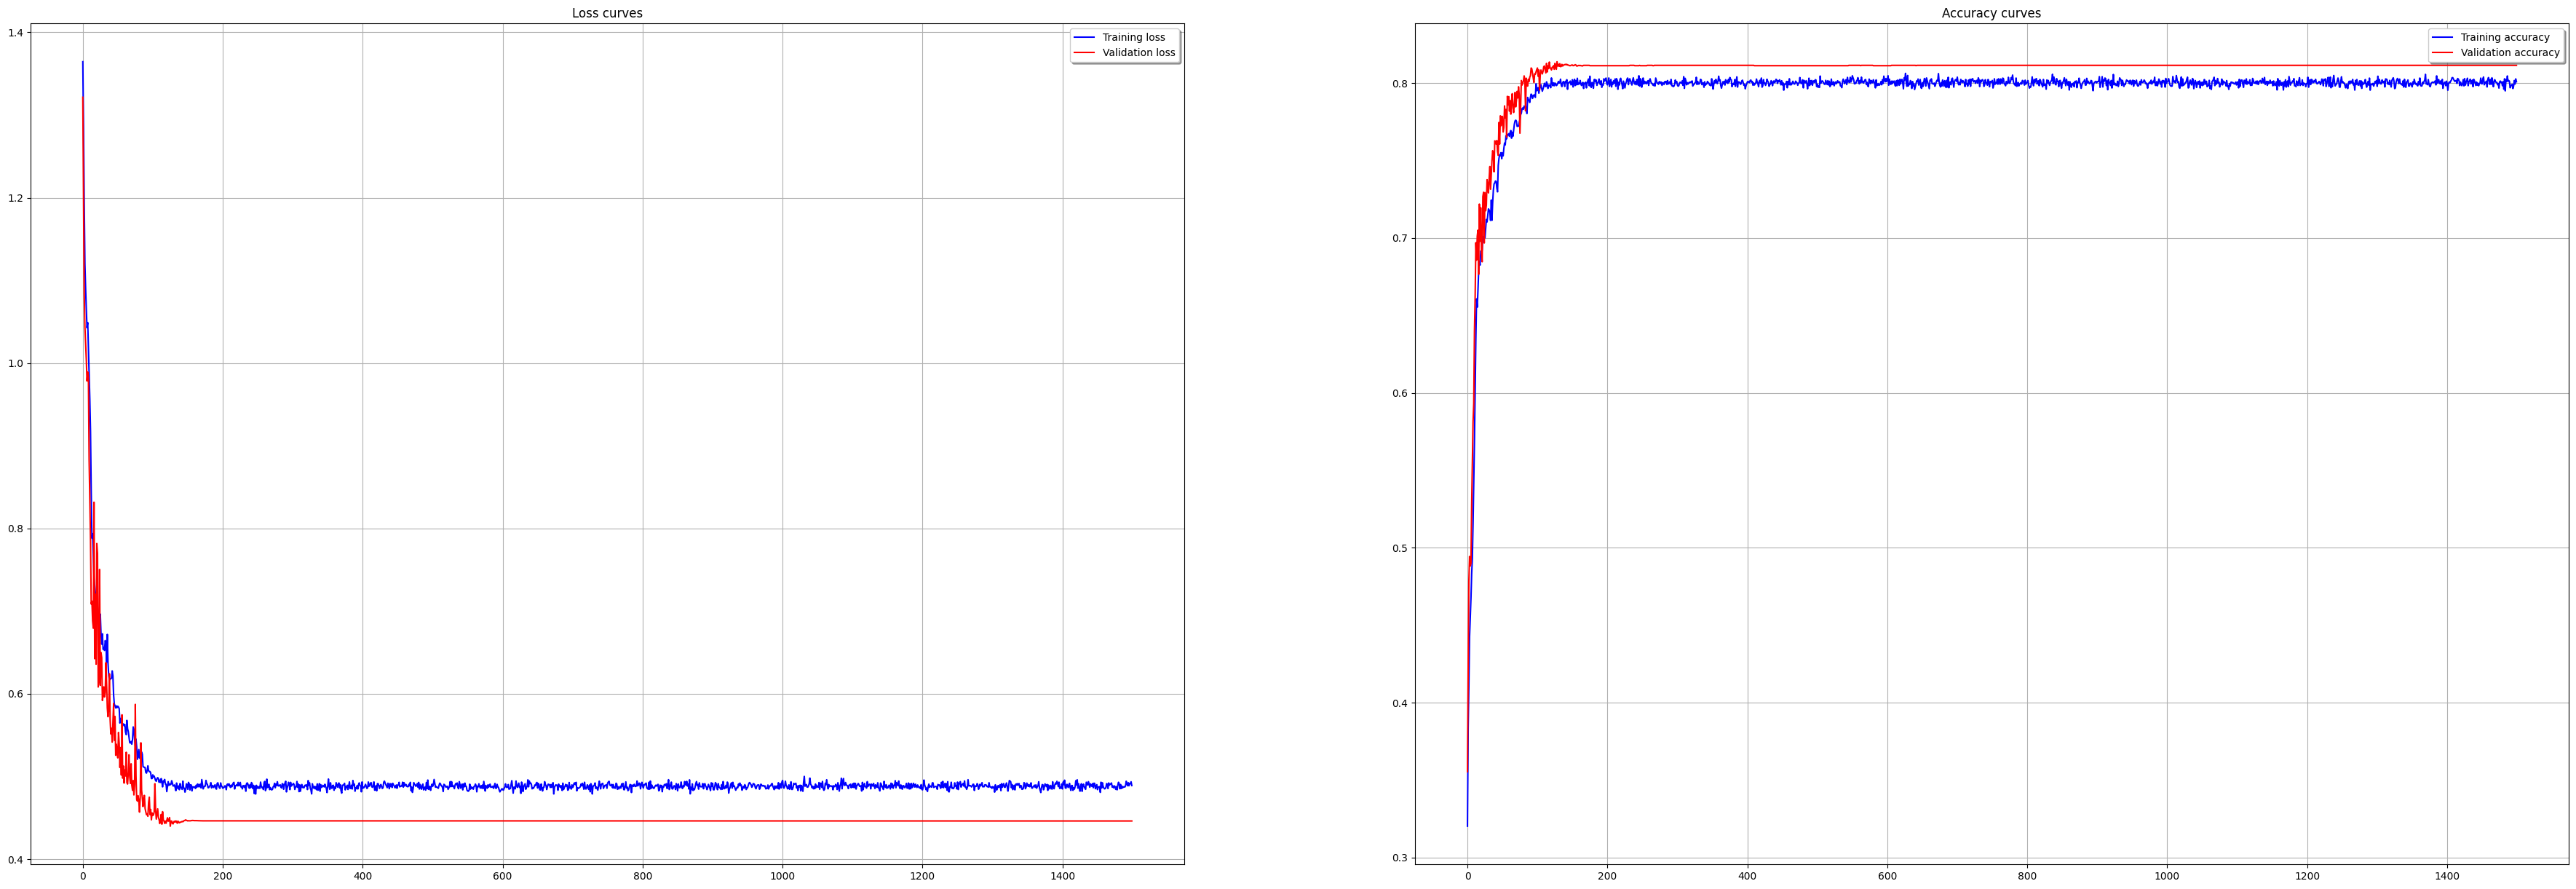

147/147 [==============================] - 5s 36ms/step
0.8965737390934241


In [38]:
model.save("model_CNN_simple3.keras")


train_loss, train_accuracy = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=X_train_partial.shape[1],
                                       verbose=1)

test_loss, test_accuracy = model.evaluate(X_val,
                                                    y_val,
                                                    batch_size=X_train_partial.shape[1],
                                                    verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(45,15))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].grid()
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].grid()
axs[1].legend(loc='best', shadow=True)
plt.show()

y_pred = model.predict(X_val)
print(f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average='micro'))

In [39]:
y_test_pred_np = model.predict(X_test_ready_np)

y_test_pred_class_np = y_test_pred_np.argmax(axis=1)

y_test_pred_class = pd.DataFrame(data={'id': range(y_test_pred_class_np.shape[0]), 'y': y_test_pred_class_np})
y_test_pred_class.to_csv('sol_CNN_simple3.csv', columns=['id', 'y'], index = False)

107/107 [==============================] - 4s 36ms/step


In [ ]:
# Model parameters
input_shape = (X_train_partial.shape[1], 1)  # Replace 'None' with your input length
num_classes = 4
dropout_rate = 0.3

model = Sequential()

for _ in range(5):
    model.add(Conv1D(128, 5, padding='same', activation='relu', input_shape=input_shape))
    model.add(MaxPooling1D(pool_size=2))
    model.add(Dropout(dropout_rate))

# Global Average Pooling
model.add(GlobalAveragePooling1D())

fc_neurons = [128, 128, 64]
for neurons in fc_neurons:
    model.add(Dense(neurons, activation='relu'))
    model.add(Dropout(dropout_rate))

# Softmax output layer
model.add(Dense(num_classes, activation='softmax'))

# Compile the model with Adam optimizer
model.compile(loss='categorical_crossentropy',
              metrics=['accuracy'],
              optimizer=tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate))
print(model.summary())

# Model summary
model.summary()

In [ ]:
# Define a learning rate decay method:
lr_decay = ReduceLROnPlateau(monitor='loss', 
                             patience=10,
                             verbose=0,
                             factor=0.5,
                             min_lr=1e-6)

# Define Early Stopping:
early_stop = EarlyStopping(monitor='val_accuracy',
                           min_delta=0, 
                           patience=50,
                           verbose=1,
                           mode='max',
                           baseline=0.75,
                           start_from_epoch=1,
                           restore_best_weights=True)

In [ ]:
start = time.time()
History = model.fit(X_train_partial,
                    y_train_partial,
                    epochs=1000,
                    batch_size=4096,
                    validation_split=0.0,
                    validation_data=(X_val, y_val),
                    shuffle=True,
                    callbacks=[lr_decay, early_stop],
                    verbose=1)

print('-'*65)
print(f'Training was completed in {time.time() - start:.2f} secs')
print('-'*65)

In [ ]:
model.save("model_CNN_simple4.keras")

In [ ]:
# Evaluate the model:
train_loss, train_accuracy = model.evaluate(X_train_partial,
                                       y_train_partial,
                                       batch_size=X_train_partial.shape[1],
                                       verbose=1)

test_loss, test_accuracy = model.evaluate(X_val,
                                                    y_val,
                                                    batch_size=X_train_partial.shape[1],
                                                    verbose=1)
print('-'*65)
print(f'train accuracy = {round(train_accuracy * 100, 4)}%')
print(f'test accuracy = {round(test_accuracy * 100, 4)}%')


# Plot the loss and accuracy curves over epochs:
fig, axs = plt.subplots(nrows=1, ncols=2, figsize=(45,15))
axs[0].plot(History.history['loss'], color='b', label='Training loss')
axs[0].plot(History.history['val_loss'], color='r', label='Validation loss')
axs[0].set_title("Loss curves")
axs[0].grid()
axs[0].legend(loc='best', shadow=True)
axs[1].plot(History.history['accuracy'], color='b', label='Training accuracy')
axs[1].plot(History.history['val_accuracy'], color='r', label='Validation accuracy')
axs[1].set_title("Accuracy curves")
axs[1].grid()
axs[1].legend(loc='best', shadow=True)
plt.show()

y_pred = model.predict(X_val)
print(f1_score(y_val.argmax(axis=1), y_pred.argmax(axis=1), average='micro'))

In [ ]:
y_test_pred_np = model.predict(X_test_ready_np)

y_test_pred_class_np = y_test_pred_np.argmax(axis=1)

y_test_pred_class = pd.DataFrame(data={'id': range(y_test_pred_class_np.shape[0]), 'y': y_test_pred_class_np})
y_test_pred_class.to_csv('sol_CNN_simple4.csv', columns=['id', 'y'], index = False)